In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import os
path="/content/gdrive/My Drive/nlp_project2"
os.chdir(path)

In [3]:
import keras
import nltk
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
url = 'https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv'
df = pd.read_csv(url, sep='\t')

In [6]:
df.head(5)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
X=df['Phrase']
Y=df['Sentiment']
x_train,x_test,y_train,y_test=train_test_split(X, Y, 
                                               test_size=0.3, random_state=2003)

In [8]:
print('data size before cleaning\n')
print('x_train:', x_train.shape, '\n', 
      'x_test:', x_test.shape,'\n', 
      'y_train:', y_train.shape, '\n', 
      'y_test:', y_test.shape, '\n')

data size before cleaning

x_train: (109242,) 
 x_test: (46818,) 
 y_train: (109242,) 
 y_test: (46818,) 



In [0]:
dtrain={'Phrase':x_train, 'Sentiment':y_train}
train=pd.DataFrame(data=dtrain)
train=train.reset_index(drop=True)

dtest={'Phrase':x_test, 'Sentiment':y_test}
test=pd.DataFrame(data=dtest)
test=test.reset_index(drop=True)

In [0]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
#stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

In [0]:
def tokenize_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [0]:
train['Phrase']=tokenize_review(train['Phrase'])

In [0]:
from sklearn.utils import resample
train_2 = train[train['Sentiment']==2]
train_1 = train[train['Sentiment']==1]
train_3 = train[train['Sentiment']==3]
train_4 = train[train['Sentiment']==4]
train_5 = train[train['Sentiment']==0]
train_2_sample = resample(train_2,replace=True,n_samples=25000,random_state=2003)
train_1_sample = resample(train_1,replace=True,n_samples=25000,random_state=2003)
train_3_sample = resample(train_3,replace=True,n_samples=25000,random_state=2003)
train_4_sample = resample(train_4,replace=True,n_samples=25000,random_state=2003)
train_5_sample = resample(train_5,replace=True,n_samples=25000,random_state=2003)

train_upsampled = pd.concat([train_2, train_1_sample,train_3_sample,train_4_sample,train_5_sample])

In [0]:
test['Phrase']=tokenize_review(test['Phrase'])

In [0]:
x_train=train_upsampled['Phrase']
x_test=test['Phrase']

In [0]:
from keras.utils import to_categorical

y_train=train_upsampled['Sentiment']
y_train=to_categorical(y_train)
y_test=test['Sentiment']
y_test=to_categorical(y_test)

In [17]:
total_words=' '.join(x_train)
total_words=word_tokenize(total_words)
distribution=FreqDist(total_words)

num_unique_words=len(distribution)
print('number of words in training:', num_unique_words)

number of words in training: 13699


In [18]:
phrase_length=[]
for text in x_train:
  word=word_tokenize(text)
  l=len(word)
  phrase_length.append(l)

max_phrase_length=np.max(phrase_length)
print('number of words in the longest phrase:', max_phrase_length)

number of words in the longest phrase: 48


In [0]:
from keras.preprocessing.text import Tokenizer
tokenize=Tokenizer(num_words=num_unique_words)
tokenize.fit_on_texts(x_train)

x_train=tokenize.texts_to_sequences(x_train)
x_test=tokenize.texts_to_sequences(x_test)

In [0]:
from keras.preprocessing.sequence import sequence
x_train=sequence.pad_sequences(x_train, maxlen=max_phrase_length)
x_test=sequence.pad_sequences(x_test, maxlen=max_phrase_length)

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LSTM
from keras import backend as K 
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

In [0]:
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return true_positives / (predicted_positives + K.epsilon())

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#LSTM

In [23]:
model_lstm=Sequential(name='LSTM')
model_lstm.add(Embedding(num_unique_words,100,name='embedding'))
model_lstm.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name='lstm_0'))
model_lstm.add(LSTM(32,dropout=0.3, recurrent_dropout=0.3, return_sequences=False, name='lstm_1'))
model_lstm.add(Dense(5,activation='softmax', name='dense'))

model_lstm.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy',recall,precision,f1])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [24]:
model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1369900   
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 1,424,721
Trainable params: 1,424,721
Non-trainable params: 0
_________________________________________________________________


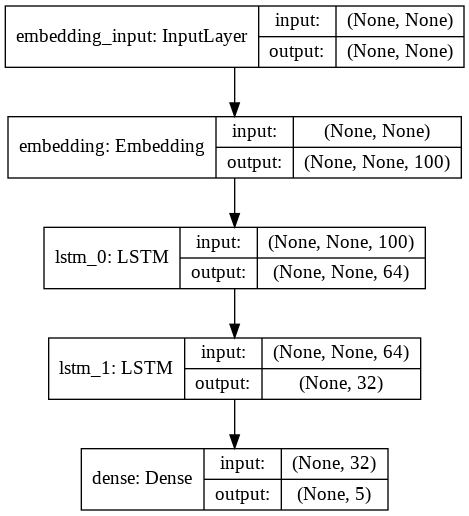

In [25]:
plot_model(model_lstm, 'LSTM.png',show_shapes=True)

In [26]:
checkpoint = ModelCheckpoint('model_lstm.{epoch:02d}-{val_f1:.5f}.h5', 
                             monitor='val_f1', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max', period=1)


history = model_lstm.fit(x_train, y_train, epochs=20, batch_size=128, 
               callbacks=[checkpoint], validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 155595 samples, validate on 46818 samples
Epoch 1/20





155595/155595 [==============================] - 182s 1ms/step - loss: 1.0666 - acc: 0.5701 - recall: 0.4094 - precision: 0.6780 - f1: 0.4998 - val_loss: 0.9657 - val_acc: 0.5983 - val_recall: 0.4847 - val_precision: 0.6558 - val_f1: 0.5570

Epoch 00001: val_f1 improved from -inf to 0.55702, saving model to model_lstm.01-0.55702.h5
Epoch 2/20
155595/155595 [==============================] - 173s 1ms/step - loss: 0.8375 - acc: 0.6635 - recall: 0.5695 - precision: 0.7261 - f1: 0.6379 - val_loss: 0.9551 - val_acc: 0.6037 - val_recall: 0.5130 - val_precision: 0.6510 - val_f1: 0.5735

Epoch 00002: val_f1 improved from 0.55702 to 0.57352, saving model to model_lstm.02-0.57352.h5
Epoch 3/20
155595/155595 [==============================] - 170s 1ms/step - loss: 0.7656 - acc: 0.6975 - recall: 0.6288 - precision: 0.7447 - f1: 0.6816 -

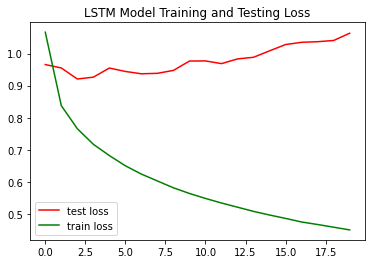

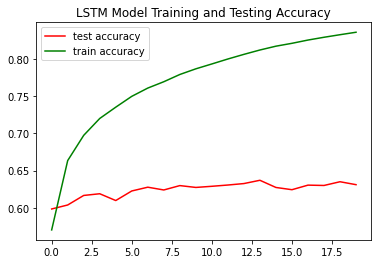

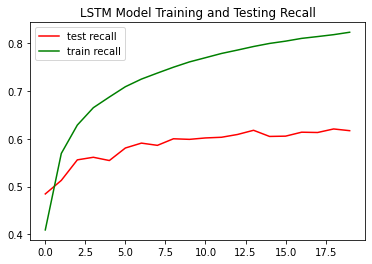

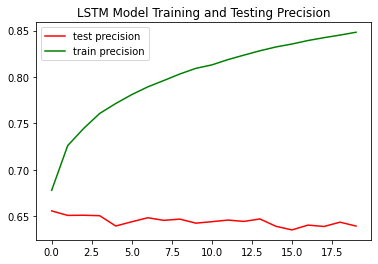

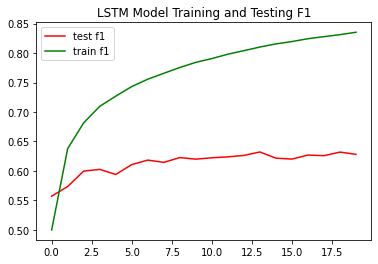

In [30]:
epochs=history.params['epochs']

import matplotlib.pyplot as plt
x=range(epochs)
test_loss=history.history['val_loss']
train_loss=history.history['loss']
test_acc=history.history['val_acc']
train_acc=history.history['acc']
test_recall=history.history['val_recall']
train_recall=history.history['recall']
test_precision=history.history['val_precision']
train_precision=history.history['precision']
test_f1=history.history['val_f1']
train_f1=history.history['f1']

plt.plot(x, test_loss,'r')
plt.plot(x, train_loss,'g')
plt.title('LSTM Model Training and Testing Loss')
plt.legend(['test loss', 'train loss'])

plt.figure()
plt.plot(x, test_acc, 'r')
plt.plot(x, train_acc, 'g')
plt.title('LSTM Model Training and Testing Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

plt.figure()
plt.plot(x, test_recall, 'r')
plt.plot(x, train_recall, 'g')
plt.title('LSTM Model Training and Testing Recall')
plt.legend(['test recall', 'train recall'])

plt.figure()
plt.plot(x, test_precision, 'r')
plt.plot(x, train_precision, 'g')
plt.title('LSTM Model Training and Testing Precision')
plt.legend(['test precision', 'train precision'])

plt.figure()
plt.plot(x, test_f1, 'r')
plt.plot(x, train_f1, 'g')
plt.title('LSTM Model Training and Testing F1')
plt.legend(['test f1', 'train f1'])

#BiLSTM


In [0]:
from keras.layers import Bidirectional

model_bilstm=Sequential(name='BiLSTM')
model_bilstm.add(Embedding(num_unique_words,100,name='embedding'))
model_bilstm.add(Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name='bilstm_0')))
model_bilstm.add(Bidirectional(LSTM(32,dropout=0.3, recurrent_dropout=0.3, return_sequences=False, name='bilstm_1')))
model_bilstm.add(Dense(5,activation='softmax', name='dense'))

model_bilstm.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy',recall,precision,f1])

In [33]:
model_bilstm.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1369900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 1,495,921
Trainable params: 1,495,921
Non-trainable params: 0
_________________________________________________________________


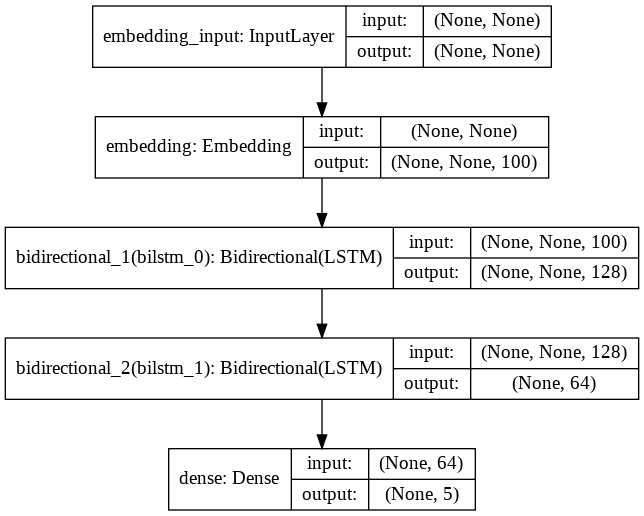

In [34]:
plot_model(model_bilstm, 'BiLSTM.png',show_shapes=True)

In [36]:
checkpoint1 = ModelCheckpoint('model_bilstm.{epoch:02d}-{val_f1:.5f}.h5', 
                             monitor='val_f1', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max', period=1)


history1 = model_bilstm.fit(x_train, y_train, epochs=20, batch_size=128, 
               callbacks=[checkpoint1], validation_data=(x_test, y_test))

Train on 155595 samples, validate on 46818 samples
Epoch 1/20
155595/155595 [==============================] - 323s 2ms/step - loss: 1.0438 - acc: 0.5776 - recall: 0.4195 - precision: 0.6857 - f1: 0.5114 - val_loss: 0.9706 - val_acc: 0.5914 - val_recall: 0.4730 - val_precision: 0.6496 - val_f1: 0.5470

Epoch 00001: val_f1 improved from -inf to 0.54704, saving model to model_bilstm.01-0.54704.h5
Epoch 2/20
155595/155595 [==============================] - 325s 2ms/step - loss: 0.8279 - acc: 0.6670 - recall: 0.5757 - precision: 0.7256 - f1: 0.6416 - val_loss: 0.9528 - val_acc: 0.6009 - val_recall: 0.5227 - val_precision: 0.6426 - val_f1: 0.5762

Epoch 00002: val_f1 improved from 0.54704 to 0.57622, saving model to model_bilstm.02-0.57622.h5
Epoch 3/20
155595/155595 [==============================] - 321s 2ms/step - loss: 0.7530 - acc: 0.7027 - recall: 0.6382 - precision: 0.7463 - f1: 0.6878 - val_loss: 0.9220 - val_acc: 0.6162 - val_recall: 0.5491 - val_precision: 0.6512 - val_f1: 0.5956


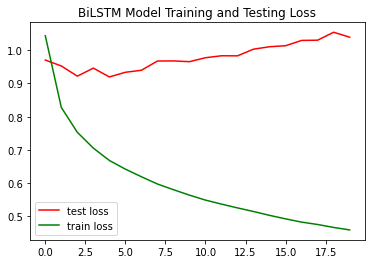

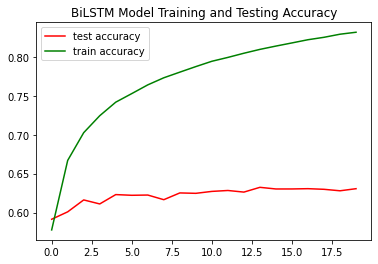

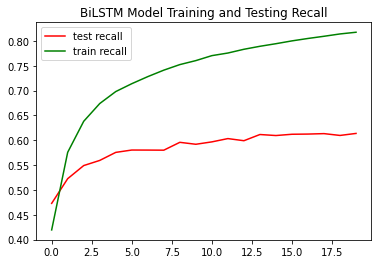

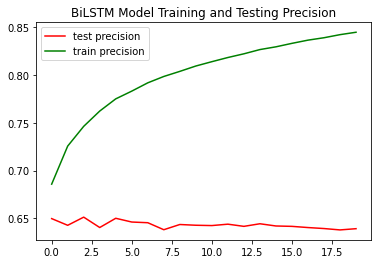

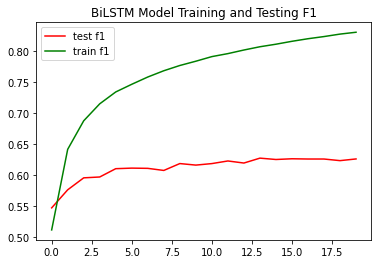

In [37]:
epochs=history1.params['epochs']

x=range(epochs)
test_loss=history1.history['val_loss']
train_loss=history1.history['loss']
test_acc=history1.history['val_acc']
train_acc=history1.history['acc']
test_recall=history1.history['val_recall']
train_recall=history1.history['recall']
test_precision=history1.history['val_precision']
train_precision=history1.history['precision']
test_f1=history1.history['val_f1']
train_f1=history1.history['f1']

plt.plot(x, test_loss,'r')
plt.plot(x, train_loss,'g')
plt.title('BiLSTM Model Training and Testing Loss')
plt.legend(['test loss', 'train loss'])

plt.figure()
plt.plot(x, test_acc, 'r')
plt.plot(x, train_acc, 'g')
plt.title('BiLSTM Model Training and Testing Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

plt.figure()
plt.plot(x, test_recall, 'r')
plt.plot(x, train_recall, 'g')
plt.title('BiLSTM Model Training and Testing Recall')
plt.legend(['test recall', 'train recall'])

plt.figure()
plt.plot(x, test_precision, 'r')
plt.plot(x, train_precision, 'g')
plt.title('BiLSTM Model Training and Testing Precision')
plt.legend(['test precision', 'train precision'])

plt.figure()
plt.plot(x, test_f1, 'r')
plt.plot(x, train_f1, 'g')
plt.title('BiLSTM Model Training and Testing F1')
plt.legend(['test f1', 'train f1'])

#CNN

In [0]:
model_cnn=Sequential(name='CNN Model')
model_cnn.add(Embedding(num_unique_words, 100, input_length=max_phrase_length,name='embedding'))
model_cnn.add(Conv1D(64, 3, padding='same', activation='relu', name='conv1d_0'))
model_cnn.add(MaxPooling1D(2, name='maxpooling1d_0'))
model_cnn.add(Conv1D(128, 3, padding='same', activation='relu', name='conv1d_1'))
model_cnn.add(MaxPooling1D(2, name='maxpooling1d_1'))
model_cnn.add(Flatten(name='flatten'))
model_cnn.add(Dense(128, activation='relu', name='dense_0'))
model_cnn.add(Dense(5, activation='softmax', name='dense_1'))

model_cnn.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['acc', recall, precision, f1])

In [40]:
model_cnn.summary()

Model: "CNN Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 100)           1369900   
_________________________________________________________________
conv1d_0 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
maxpooling1d_0 (MaxPooling1D (None, 24, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 128)           24704     
_________________________________________________________________
maxpooling1d_1 (MaxPooling1D (None, 12, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               19

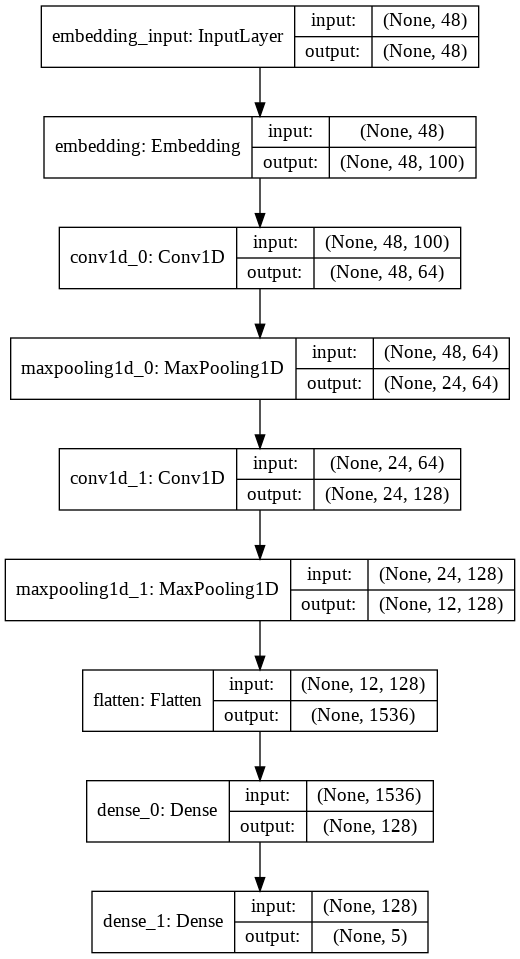

In [41]:
plot_model(model_cnn, 'CNN.png',show_shapes=True)

In [43]:
checkpoint2 = ModelCheckpoint('model_cnn.{epoch:02d}-{val_f1:.5f}.h5', 
                             monitor='val_f1', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max', period=1)


history2 = model_cnn.fit(x_train, y_train, epochs=20, batch_size=128, 
               callbacks=[checkpoint2], validation_data=(x_test, y_test))

Train on 155595 samples, validate on 46818 samples
Epoch 1/20
155595/155595 [==============================] - 13s 81us/step - loss: 0.9782 - acc: 0.6039 - recall: 0.4600 - precision: 0.6973 - f1: 0.5462 - val_loss: 0.8910 - val_acc: 0.6345 - val_recall: 0.5620 - val_precision: 0.6747 - val_f1: 0.6129

Epoch 00001: val_f1 improved from -inf to 0.61294, saving model to model_cnn.01-0.61294.h5
Epoch 2/20
155595/155595 [==============================] - 7s 43us/step - loss: 0.6947 - acc: 0.7265 - recall: 0.6712 - precision: 0.7662 - f1: 0.7152 - val_loss: 0.9508 - val_acc: 0.6327 - val_recall: 0.5974 - val_precision: 0.6556 - val_f1: 0.6250

Epoch 00002: val_f1 improved from 0.61294 to 0.62504, saving model to model_cnn.02-0.62504.h5
Epoch 3/20
155595/155595 [==============================] - 7s 43us/step - loss: 0.5783 - acc: 0.7800 - recall: 0.7465 - precision: 0.8049 - f1: 0.7744 - val_loss: 0.9886 - val_acc: 0.6181 - val_recall: 0.5774 - val_precision: 0.6408 - val_f1: 0.6073

Epoch 0

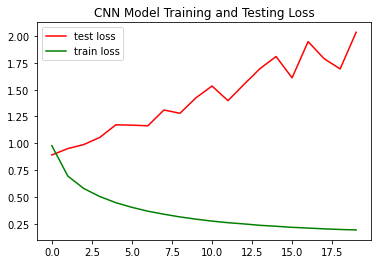

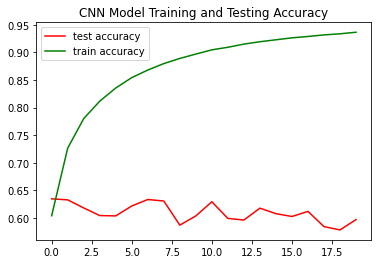

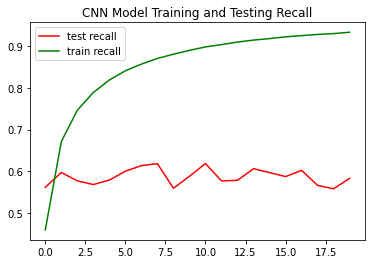

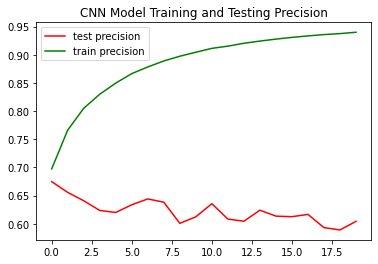

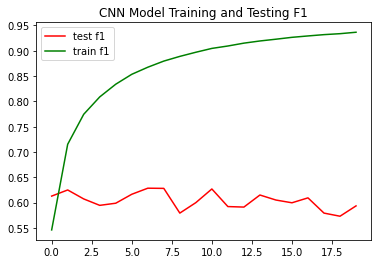

In [45]:
epochs=history2.params['epochs']

import matplotlib.pyplot as plt
x=range(epochs)
test_loss=history2.history['val_loss']
train_loss=history2.history['loss']
test_acc=history2.history['val_acc']
train_acc=history2.history['acc']
test_recall=history2.history['val_recall']
train_recall=history2.history['recall']
test_precision=history2.history['val_precision']
train_precision=history2.history['precision']
test_f1=history2.history['val_f1']
train_f1=history2.history['f1']

plt.plot(x, test_loss,'r')
plt.plot(x, train_loss,'g')
plt.title('CNN Model Training and Testing Loss')
plt.legend(['test loss', 'train loss'])

plt.figure()
plt.plot(x, test_acc, 'r')
plt.plot(x, train_acc, 'g')
plt.title('CNN Model Training and Testing Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

plt.figure()
plt.plot(x, test_recall, 'r')
plt.plot(x, train_recall, 'g')
plt.title('CNN Model Training and Testing Recall')
plt.legend(['test recall', 'train recall'])

plt.figure()
plt.plot(x, test_precision, 'r')
plt.plot(x, train_precision, 'g')
plt.title('CNN Model Training and Testing Precision')
plt.legend(['test precision', 'train precision'])

plt.figure()
plt.plot(x, test_f1, 'r')
plt.plot(x, train_f1, 'g')
plt.title('CNN Model Training and Testing F1')
plt.legend(['test f1', 'train f1'])

#CNN&LSTM

In [0]:
model_cnn_lstm=Sequential(name='CNN LSTM Model')
model_cnn_lstm.add(Embedding(num_unique_words, 100, input_length=max_phrase_length,name='embedding'))
model_cnn_lstm.add(Conv1D(64, 3, padding='same', activation='relu', name='conv1d_0'))
model_cnn_lstm.add(MaxPooling1D(2, name='maxpooling1d_0'))
model_cnn_lstm.add(LSTM(64,dropout=0.3, recurrent_dropout=0.3, return_sequences=True, name='lstm_0'))
model_cnn_lstm.add(Flatten(name='flatten'))
model_cnn_lstm.add(Dense(128, activation='relu', name='dense_0'))
model_cnn_lstm.add(Dense(5, activation='softmax', name='dense_1'))

model_cnn_lstm.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['acc', recall, precision, f1])

In [47]:
model_cnn_lstm.summary()

Model: "CNN LSTM Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 100)           1369900   
_________________________________________________________________
conv1d_0 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
maxpooling1d_0 (MaxPooling1D (None, 24, 64)            0         
_________________________________________________________________
lstm_0 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 5)              

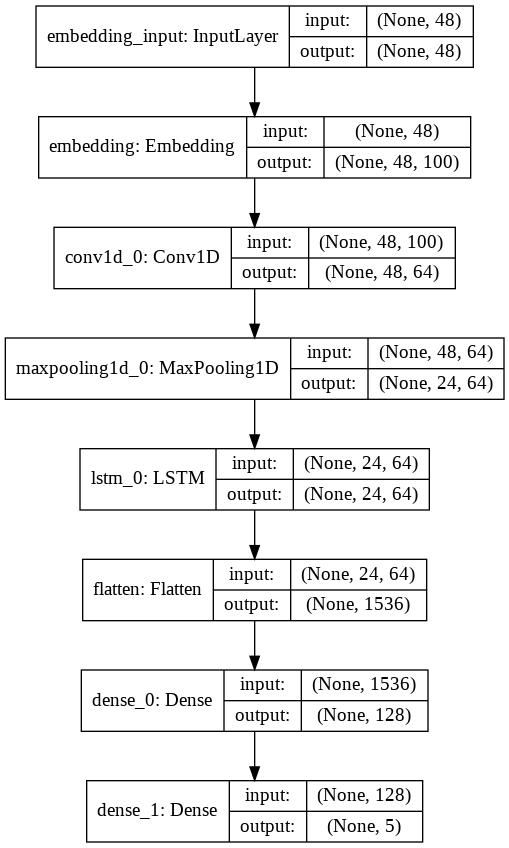

In [48]:
plot_model(model_cnn_lstm, 'CNN&LSTM.png',show_shapes=True)

In [49]:
checkpoint3 = ModelCheckpoint('model_cnn_lstm.{epoch:02d}-{val_f1:.5f}.h5', 
                             monitor='val_f1', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max', period=1)


history3 = model_cnn_lstm.fit(x_train, y_train, epochs=20, batch_size=128, 
               callbacks=[checkpoint3], validation_data=(x_test, y_test))

Train on 155595 samples, validate on 46818 samples
Epoch 1/20
155595/155595 [==============================] - 55s 356us/step - loss: 1.0319 - acc: 0.5819 - recall: 0.4243 - precision: 0.6944 - f1: 0.5171 - val_loss: 0.9718 - val_acc: 0.5913 - val_recall: 0.4812 - val_precision: 0.6520 - val_f1: 0.5533

Epoch 00001: val_f1 improved from -inf to 0.55331, saving model to model_cnn_lstm.01-0.55331.h5
Epoch 2/20
155595/155595 [==============================] - 53s 344us/step - loss: 0.7900 - acc: 0.6826 - recall: 0.5949 - precision: 0.7423 - f1: 0.6600 - val_loss: 0.9543 - val_acc: 0.5984 - val_recall: 0.5054 - val_precision: 0.6447 - val_f1: 0.5663

Epoch 00002: val_f1 improved from 0.55331 to 0.56633, saving model to model_cnn_lstm.02-0.56633.h5
Epoch 3/20
155595/155595 [==============================] - 53s 342us/step - loss: 0.7015 - acc: 0.7229 - recall: 0.6616 - precision: 0.7666 - f1: 0.7100 - val_loss: 0.9658 - val_acc: 0.5992 - val_recall: 0.5338 - val_precision: 0.6368 - val_f1: 

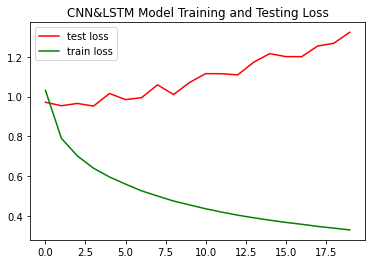

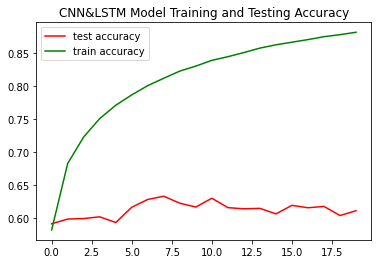

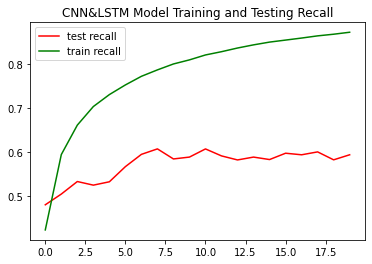

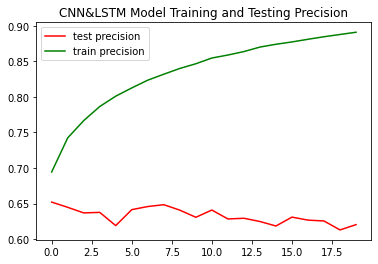

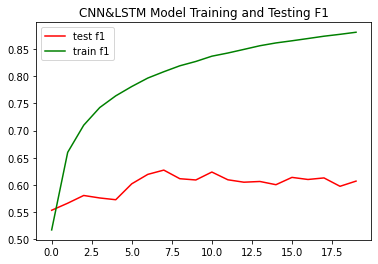

In [50]:
epochs=history3.params['epochs']

import matplotlib.pyplot as plt
x=range(epochs)
test_loss=history3.history['val_loss']
train_loss=history3.history['loss']
test_acc=history3.history['val_acc']
train_acc=history3.history['acc']
test_recall=history3.history['val_recall']
train_recall=history3.history['recall']
test_precision=history3.history['val_precision']
train_precision=history3.history['precision']
test_f1=history3.history['val_f1']
train_f1=history3.history['f1']

plt.plot(x, test_loss,'r')
plt.plot(x, train_loss,'g')
plt.title('CNN&LSTM Model Training and Testing Loss')
plt.legend(['test loss', 'train loss'])

plt.figure()
plt.plot(x, test_acc, 'r')
plt.plot(x, train_acc, 'g')
plt.title('CNN&LSTM Model Training and Testing Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

plt.figure()
plt.plot(x, test_recall, 'r')
plt.plot(x, train_recall, 'g')
plt.title('CNN&LSTM Model Training and Testing Recall')
plt.legend(['test recall', 'train recall'])

plt.figure()
plt.plot(x, test_precision, 'r')
plt.plot(x, train_precision, 'g')
plt.title('CNN&LSTM Model Training and Testing Precision')
plt.legend(['test precision', 'train precision'])

plt.figure()
plt.plot(x, test_f1, 'r')
plt.plot(x, train_f1, 'g')
plt.title('CNN&LSTM Model Training and Testing F1')
plt.legend(['test f1', 'train f1'])

#Model Comparison

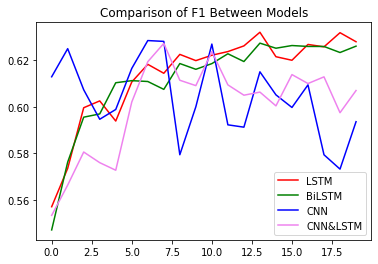

In [51]:
x=range(epochs)

lstm_f1=history.history['val_f1']
bilstm_f1=history1.history['val_f1']
cnn_f1=history2.history['val_f1']
cnn_lstm_f1=history3.history['val_f1']

plt.figure()
plt.plot(x, lstm_f1,'r')
plt.plot(x, bilstm_f1,'g')
plt.plot(x, cnn_f1,'b')
plt.plot(x, cnn_lstm_f1,'violet')
plt.title('Comparison of F1 Between Models')
plt.legend(['LSTM','BiLSTM', 'CNN', 
            'CNN&LSTM' ])

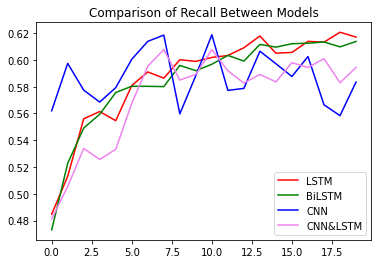

In [52]:
lstm_recall=history.history['val_recall']
bilstm_recall=history1.history['val_recall']
cnn_recall=history2.history['val_recall']
cnn_lstm_recall=history3.history['val_recall']

plt.figure()
plt.plot(x, lstm_recall,'r')
plt.plot(x, bilstm_recall,'g')
plt.plot(x, cnn_recall,'b')
plt.plot(x, cnn_lstm_recall,'violet')
plt.title('Comparison of Recall Between Models')
plt.legend(['LSTM','BiLSTM', 'CNN', 
            'CNN&LSTM' ])

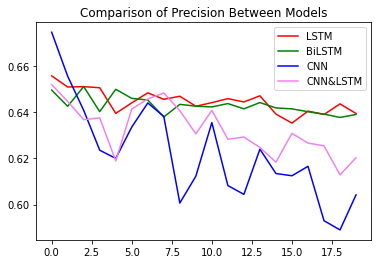

In [55]:
lstm_precision=history.history['val_precision']
bilstm_precision=history1.history['val_precision']
cnn_precision=history2.history['val_precision']
cnn_lstm_precision=history3.history['val_precision']

plt.figure()
plt.plot(x, lstm_precision,'r')
plt.plot(x, bilstm_precision,'g')
plt.plot(x, cnn_precision,'b')
plt.plot(x, cnn_lstm_precision,'violet')
plt.title('Comparison of Precision Between Models')
plt.legend(['LSTM','BiLSTM', 'CNN', 
            'CNN&LSTM' ])

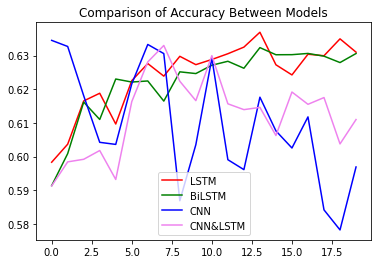

In [56]:
lstm_acc=history.history['val_acc']
bilstm_acc=history1.history['val_acc']
cnn_acc=history2.history['val_acc']
cnn_lstm_acc=history3.history['val_acc']

plt.figure()
plt.plot(x, lstm_acc,'r')
plt.plot(x, bilstm_acc,'g')
plt.plot(x, cnn_acc,'b')
plt.plot(x, cnn_lstm_acc,'violet')
plt.title('Comparison of Accuracy Between Models')
plt.legend(['LSTM','BiLSTM', 'CNN', 
            'CNN&LSTM' ])

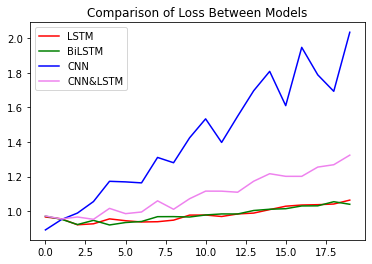

In [57]:
lstm_loss=history.history['val_loss']
bilstm_loss=history1.history['val_loss']
cnn_loss=history2.history['val_loss']
cnn_lstm_loss=history3.history['val_loss']

plt.figure()
plt.plot(x, lstm_loss,'r')
plt.plot(x, bilstm_loss,'g')
plt.plot(x, cnn_loss,'b')
plt.plot(x, cnn_lstm_loss,'violet')
plt.title('Comparison of Loss Between Models')
plt.legend(['LSTM','BiLSTM', 'CNN', 
            'CNN&LSTM' ])